# REINFORCE recommender agent

```
Top-K Off-Policy Correction for a REINFORCE Recommender System
Minmin Chen, Alex Beutel, Paul Covington, Sagar Jain, Francois Belletti, Ed Chi
https://arxiv.org/pdf/1812.02353.pdf
```
This notebook steps details how to train and evaluate the REINFORCE Recommender agent from the paper above. 

## env setup

if implementing a scann index for efficient `action retreival` function, install `scann` (and version):

> scann==1.2.10

In [1]:
VERSION        = "v2"                       # TODO
PREFIX         = f'rec-bandits-{VERSION}'   # TODO

print(f"PREFIX: {PREFIX}")

PREFIX: rec-bandits-v2


In [2]:
# staging GCS
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "hybrid-vertex"
PROJECT_NUM              = "934903580331"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"
VERTEX_SA                = "934903580331-compute@developer.gserviceaccount.com"

PREFIX                   = "rec-bandits-v2"
VERSION                  = "v2"

BUCKET_NAME              = "rec-bandits-v2-hybrid-vertex-bucket"
BUCKET_URI               = "gs://rec-bandits-v2-hybrid-vertex-bucket"
DATA_GCS_PREFIX          = "data"
DATA_PATH                = "gs://rec-bandits-v2-hybrid-vertex-bucket/data"
VOCAB_SUBDIR             = "vocabs"
VOCAB_FILENAME           = "vocab_dict.pkl"

VPC_NETWORK_FULL         = "projects/934903580331/global/networks/ucaip-haystack-vpc-network"

BIGQUERY_DATASET_NAME    = "mvlens_rec_bandits_v2"
BIGQUERY_TABLE_NAME      = "training_dataset"

REPOSITORY               = "rl-movielens-rec-bandits-v2"

DOCKERNAM

### imports

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [5]:
import time
import functools
import collections
import pickle as pkl
from pprint import pprint
from collections import defaultdict
from datetime import datetime
from typing import Callable, Dict, List, Optional, TypeVar

# logging
import logging
logging.disable(logging.WARNING)

import matplotlib.pyplot as plt
import numpy as np

# google cloud
from google.cloud import aiplatform, storage

# tensorflow
import tensorflow as tf

# tf-agents
from tf_agents.utils import common
from tf_agents.specs import tensor_spec
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.metrics import export_utils
from tf_agents.policies import policy_saver
from tf_agents.trajectories import trajectory
from tf_agents.train.utils import strategy_utils
from tf_agents.policies import py_tf_eager_policy
from tf_agents.trajectories import time_step as ts

from tf_agents.replay_buffers import tf_uniform_replay_buffer

# GPU
from numba import cuda 
import gc

# tf exceptions and vars
if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

# this repo
import sys
sys.path.append("..")

from src.data import data_utils as data_utils
from src.data import data_config as data_config
from src.agents import rfa_utils as rfa_utils
from src.networks import encoding_network as emb_features

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
device = cuda.get_current_device()
device.reset()
gc.collect()

14

In [9]:
print(f"device: {device.name.decode()}")

device: Tesla T4


In [10]:
# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# Vertex client
aiplatform.init(project=PROJECT_ID, location=LOCATION)

## Sequence data

For each `user`, we consider a sequence of user historical interactions with the RecSys, recording the actions taken by the recommender (e.g., items recommended), as well as user feedback (e.g.,`ratings`)

Given such a sequence, we predict the next `action` to take, i.e., items to recommend, so that user satisfaction metrics, e.g., indicated by `ratings` improve

**MPD definiton**

> We translate this setup into a Markov Decision Process (MDP)

**{`S`, `A`, `P`, `R`, `p0`, `y`}**

* **`S`**: a continuous state space describing the user states
* **`A`**: a discrete action space, containing items available for recommendation
* **`P`** : S × A × S → R is the state transition probability
* **`R`** : S × A → R is the reward function, where 𝑟(𝑠, 𝑎) is the immediate reward obtained by performing action 𝑎 at user state `s`
* **`p0`** is the initial state distribution
* **`y`** is the discount factor for future rewards

### Trajectories

**A `Trajectory` represents a sequence of aligned time steps** 

It captures:
* `observation` and `step_type` from current time step with the computed `action` and `policy_info`
* `Discount`, `reward` and `next_step_type` come from the next time step.
  
We allow `experience` to contain trajectories of different lengths in the *time dimension*, but these have to be padded with dummy values to have a constant size of `T` in the time dimension

* Both `trajectory.reward` and `weights` have to be 0 for these dummy values
* `experience` can be provided in other formats such as `Transition`'s if they can be converted into Trajectories.

### TimeSteps

**A `TimeStep` contains the data emitted by an environment at each step of interaction**. They include:
* a `step_type`, 
* an `observation` (e.g., NumPy array, dict, or list of arrays), 
* and an associated `reward` and `discount`

**sequential ordering**
* first `TimeStep` in a sequence equals `StepType.FIRST`
* final `TimeStep` in a sequence equals `StepType.LAST`
* All other `TimeStep`s in a sequence equal `StepType.MID`

### Discounted rewards

> A discounting factor is introduced for:
* Reducing variance 
* Prescribing the effective time horizon we optimize over

## Parse sequence examples

In [11]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.AUTO

In [12]:
EXAMPLE_GEN_GCS_PATH = data_config.EXAMPLE_GEN_GCS_PATH
GCS_DATA_PATH = f"{BUCKET_URI}/{EXAMPLE_GEN_GCS_PATH}"

print(f"GCS_DATA_PATH: {GCS_DATA_PATH}")
# !gsutil ls $GCS_DATA_PATH

GCS_DATA_PATH: gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m


In [13]:
SPLIT = "train" # "train" | "val"

train_files = []
for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{EXAMPLE_GEN_GCS_PATH}/{SPLIT}'):
    if '.tfrecord' in blob.name:
        train_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
train_files = train_files #[:3] # subset

In [14]:
train_dataset = tf.data.TFRecordDataset(train_files)
train_seq_dataset = train_dataset.map(data_utils._parse_seq_function)

# see train example
for x in train_seq_dataset.skip(5).take(1):
    pprint(x)

({'context_movie_genre': <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'Crime', b'Drama', b'Action', b'Drama', b'War', b'Crime',
       b'Drama', b'Drama', b'Drama', b'Drama'], dtype=object)>,
  'context_movie_id': <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'2199', b'108', b'1047', b'837', b'1590', b'504', b'1680', b'258',
       b'1632', b'586'], dtype=object)>,
  'context_movie_rating': <tf.Tensor: shape=(10,), dtype=float32, numpy=array([3., 4., 3., 4., 3., 3., 4., 3., 4., 5.], dtype=float32)>,
  'context_movie_title': <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'Few Good Men, A (1992)', b'Braveheart (1995)',
       b'Sleepers (1996)', b'Spitfire Grill, The (1996)',
       b"Ulee's Gold (1997)", b'Philadelphia (1993)',
       b'Jackie Brown (1997)', b'Little Women (1994)',
       b'Joy Luck Club, The (1993)', b'Dances with Wolves (1990)'],
      dtype=object)>,
  'context_movie_year': <tf.Tensor: shape=(10,), dtype=int64, numpy=array([1992, 1995, 1996, 1

### Example: proto to trajectory

> Let's inspect the trajectory structure we need for our REINFORCE recommender agent. Specifically, we'll construct a `trajectory` object and its associated *importance weights*

In [15]:
sequence_length=5

#### example proto

In [16]:
# for raw_record in train_dataset.take(1):
#     example = tf.train.Example()
#     example.ParseFromString(raw_record.numpy())
#     print(example)

In [17]:
# for raw_seq_record in train_dataset.take(1):
#     example = tf.train.SequenceExample()
#     example.ParseFromString(raw_seq_record.numpy())
#     print(example)

#### rewards

* ratings 1-5
* can cast ratings over certain threshold to create binary rewards

In [18]:
ratings_seq = x[0]['context_movie_rating'].numpy()[-sequence_length:]
ratings_seq

array([3., 4., 3., 4., 5.], dtype=float32)

In [19]:
# rewards = tf.cast(ratings_seq > 0, dtype=tf.float32) # binary rewards
rewards = ratings_seq
rewards

array([3., 4., 3., 4., 5.], dtype=float32)

#### actions and observations

For now, we are using the following simplified features:
* At every point in time, the `target_movie_id` field in the sequence is the **action** 
* the `context_movie_id` at the previous time step (previous action(s)) is the observation
* each `context_movie_id` has a corresponding `context_movie_rating`
> * possible to convert `context_movie_rating` to a binary reward (e.g., clicks)

In [20]:
x[0]['context_movie_id'] #[0]

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'2199', b'108', b'1047', b'837', b'1590', b'504', b'1680', b'258',
       b'1632', b'586'], dtype=object)>

In [21]:
actions = x[0]['context_movie_id'].numpy()[-sequence_length:]
actions

array([b'504', b'1680', b'258', b'1632', b'586'], dtype=object)

In [22]:
observations = x[0]['context_movie_id'].numpy()[-(sequence_length+1):-1]
observations

array([b'1590', b'504', b'1680', b'258', b'1632'], dtype=object)

#### pad trajectory elements

In [23]:
actual_sequence_length = tf.shape(observations)[0]
actual_sequence_length

<tf.Tensor: shape=(), dtype=int32, numpy=5>

In [24]:
actions = actions[-actual_sequence_length:]
actions

array([b'504', b'1680', b'258', b'1632', b'586'], dtype=object)

In [25]:
rewards = rewards[-actual_sequence_length:]
rewards

array([3., 4., 3., 4., 5.], dtype=float32)

In [26]:
paddings = tf.stack([0, sequence_length - actual_sequence_length])
paddings

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([0, 0], dtype=int32)>

In [27]:
paddings = tf.expand_dims(paddings, 0)
paddings

<tf.Tensor: shape=(1, 2), dtype=int32, numpy=array([[0, 0]], dtype=int32)>

In [28]:
rewards = tf.pad(rewards, paddings, 'CONSTANT', constant_values=0)
rewards

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([3., 4., 3., 4., 5.], dtype=float32)>

In [29]:
discounts = tf.ones((sequence_length,), dtype=tf.float32)
discounts

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([1., 1., 1., 1., 1.], dtype=float32)>

#### step types

The time dimension will be equal to `sequence_length` 

The agent assumes that this trajectory is a single episode, so `trajectory.step_type` and `trajectory.discount` are ignored

* `ts.StepType.FIRST` == 0
* `ts.StepType.MID` == 1
* `ts.StepType.LAST` == 2

In [30]:
next_step_types = tf.ones((sequence_length,), dtype=tf.int32) * ts.StepType.MID
next_step_types

<tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 1, 1, 1, 1], dtype=int32)>

In [31]:
step_types = tf.concat([[ts.StepType.FIRST], next_step_types[1:]], axis=0)
step_types

<tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 1, 1, 1, 1], dtype=int32)>

#### trajectory object

* `Discount` is all ones in the base trajectory. During training, we can apply different discounting values with a `gamma` parameter

In [32]:
traj = trajectory.Trajectory(
      step_type=step_types,
      observation=observations,
      action=actions,
      policy_info=(),
      next_step_type=next_step_types,
      reward=rewards,
      discount=discounts
)

traj

Trajectory(
{'action': array([b'504', b'1680', b'258', b'1632', b'586'], dtype=object),
 'discount': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([1., 1., 1., 1., 1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 1, 1, 1, 1], dtype=int32)>,
 'observation': array([b'1590', b'504', b'1680', b'258', b'1632'], dtype=object),
 'policy_info': (),
 'reward': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([3., 4., 3., 4., 5.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 1, 1, 1, 1], dtype=int32)>})

#### importance weights

> divides the trajectory into 3 parts: 

* The **first** part is used to warm start the state embedding network
* The **second** part is used to compute losses
* Returns are computed using the **second** and **third** parts

In [33]:
section_size = tf.cast(actual_sequence_length / 3, tf.int32)
section_size

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [34]:
weights = tf.concat([
    tf.zeros((section_size,)),
    tf.ones((section_size,)),
    tf.zeros((sequence_length - 2 * section_size,))
], axis=0)
weights

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 0., 0., 0.], dtype=float32)>

## Data ops

> Now let's create the helper functions for creating data pipelines for trajectories and weights

**TODO**
* abstract data ops to utils etc.

In [35]:
data_config.MAX_CONTEXT_LENGTH

10

### sequence example to trajectory

In [41]:
def example_proto_to_trajectory(
    example_proto, # sequence_feature,
    sequence_length: int
):
    """
    Converts a sequence example to a Trajectory and weights for training.

    For now, we are using the following simplified features. At every point in
    time, the `context_movie_id` field in the sequence is the action and the `context_movie_id`
    at the previous time step (last action) is the observation. The `context_movie_rating` field
    is converted to a binary reward.

    If the sequence example is longer than than `sequence_length`, we only take
    the last part of the sequence example. If it is shorter, we pad it with dummy
    values at the end to equal `sequence_length`.

    Args:
    sequence_feature: A serialized SequenceExample to convert to a
      trajectory.
    sequence_length: The time dimension of the returned trajectory.

    Returns:
    trajectory: An unbatched trajectory. The time dimension will be equal to
      sequence length. The agent assumes that this trajectory is a single
      episode, so `trajectory.step_type` and `trajectory.discount` are ignored.
    weights: A [T] float tensor of weights. Each row of `weights`
        (along the time dimension) is usually a sequence of 0's, followed by
        a sequence of 1's, again followed by a sequence of 0's. This divides
        the trajectory into 3 parts. The first part is used to warm start
        the state embedding network. The second part is used to compute
        losses. Returns are computed using the second and third parts.
    """
    
    feature_description = {
        'context_movie_id': tf.io.FixedLenFeature(shape=(data_config.MAX_CONTEXT_LENGTH), dtype=tf.string),
        'context_movie_rating': tf.io.FixedLenFeature(shape=(data_config.MAX_CONTEXT_LENGTH), dtype=tf.float32),
    }
    
    sequence_feature = tf.io.parse_single_sequence_example(example_proto, feature_description)
    # print(f"sequence_feature: {sequence_feature[0]}")
    
    # context_id_string = [z.numpy() for z in sequence_feature[0]['context_movie_id']]
    
    context_id_int = tf.strings.to_number(
        sequence_feature[0]['context_movie_id'],
        out_type=tf.dtypes.int64,
        name=None
    )
    # context_id_int = context_id_int.numpy()
    
    ### TODO: keep or remove: [0] ? 
    
    sequence_feature[0]['context_movie_id'] = context_id_int
    actions = sequence_feature[0]['context_movie_id'][-sequence_length:]
    rewards = sequence_feature[0]['context_movie_rating'][-sequence_length:]
    observations = sequence_feature[0]['context_movie_id'][-(sequence_length+1):-1]
    
    # sequence_feature['context_movie_id'] = context_id_int
    # actions = sequence_feature['context_movie_id'][-sequence_length:]
    # rewards = sequence_feature['context_movie_rating'][-sequence_length:]
    # observations = sequence_feature['context_movie_id'][-(sequence_length+1):-1]
    # print(f"observations: {observations}")

    # actual length
    actual_sequence_length = tf.shape(observations)[0]
    # print(f"actual_sequence_length: {actual_sequence_length}")
    
    actions = actions[-actual_sequence_length:]
    rewards = rewards[-actual_sequence_length:]

    # padding
    paddings = tf.stack([0, sequence_length - actual_sequence_length])
    paddings = tf.expand_dims(paddings, 0)

    rewards = tf.pad(rewards, paddings, 'CONSTANT', constant_values=0)
    actions = tf.pad(actions, paddings, 'CONSTANT', constant_values=0)
    observations = tf.pad(observations, paddings, 'CONSTANT', constant_values=0)

    # steps & discounts
    discounts = tf.ones((sequence_length,), dtype=tf.float32)
    next_step_types = tf.ones(
      (sequence_length,), dtype=tf.int32) * ts.StepType.MID
    step_types = tf.concat([[ts.StepType.FIRST], next_step_types[1:]], axis=0)

    # build trajectory
    traj = trajectory.Trajectory(
        step_type=step_types,
        observation=observations,
        action=actions,
        policy_info=(),
        next_step_type=next_step_types,
        reward=rewards,
        discount=discounts
    )

    # get importance weights
    section_size = tf.cast(actual_sequence_length / 3, tf.int32)
    # print(f"section_size: {section_size}")
    
    weights = tf.concat(
        [
            tf.zeros((section_size,)),
            tf.ones((section_size,)),
            tf.zeros((sequence_length - 2 * section_size,))
        ], 
        axis=0
    )
    
    return traj, weights # sequence_feature

### create single TF Record dataset

In [42]:
def create_single_tfrecord_ds(
    filename,
    process_example_fn,
    shuffle_buffer_size = 1,
):
    raw_ds = tf.data.TFRecordDataset(filename)
    
    ds = raw_ds.map(
        process_example_fn,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    ds = ds.shuffle(shuffle_buffer_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

### create interleaved TF Record dataset

1. Each element of a TF Record is processed using the `process_example_fn` and converted to Tensors
2. A dataset is created for each record file 
3. These datasets are interleaved together to create the final dataset

In [43]:
def create_tfrecord_ds(
    filenames,
    process_example_fn,
    batch_size: int,
    shuffle_buffer_size_per_record: int = 1,
    shuffle_buffer_size: int = 10000,
    num_shards: int = 50,
    cycle_length: int = tf.data.AUTOTUNE,
    block_length: int = 10,
    num_prefetch: int = 10,
    num_parallel_calls: int = 10,
    repeat: bool = True,
    drop_remainder: bool = False
):
    filenames = list(filenames)
    initial_len = len(filenames)
    remainder = initial_len % num_shards
    
    for _ in range(num_shards - remainder):
        filenames.append(
            filenames[np.random.randint(low=0, high=initial_len)]
        )
        
    filenames = np.array(filenames)
    np.random.shuffle(filenames)
    filenames = np.array_split(filenames, num_shards)
    filename_ds = tf.data.Dataset.from_tensor_slices(filenames)
    
    if repeat:
        filename_ds = filename_ds.repeat()
    
    filename_ds = filename_ds.shuffle(len(filenames))
    
    example_ds = filename_ds.interleave(
        functools.partial(
            create_single_tfrecord_ds,
            process_example_fn=process_example_fn,
            shuffle_buffer_size=shuffle_buffer_size_per_record,
        ),
        cycle_length=tf.data.AUTOTUNE,
        block_length=block_length,
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    example_ds = example_ds.shuffle(shuffle_buffer_size)
    
    example_ds = example_ds.batch(
        batch_size, drop_remainder=drop_remainder
    ).prefetch(num_prefetch)
  
    return example_ds

**inspect output of helper functions**

In [44]:
sequence_length=10

process_example_fn = functools.partial(
    example_proto_to_trajectory,
    sequence_length=sequence_length
)

In [45]:
train_batch_size=5

train_dataset = create_tfrecord_ds(
    tf.io.gfile.glob(train_files),
    # num_shards = 10,
    process_example_fn=process_example_fn,
    batch_size=train_batch_size
)
train_dataset_iterator = iter(train_dataset)

In [46]:
traj_test, weights = next(train_dataset_iterator)

weights

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]], dtype=float32)>

In [47]:
traj_test

Trajectory(
{'action': <tf.Tensor: shape=(5, 10), dtype=int64, numpy=
array([[2124, 2074,    0,    0,    0,    0,    0,    0,    0,    0],
       [1068, 1892, 2267, 2937,  959, 2063, 2243, 1190, 1248,    0],
       [2401, 2559,  642, 1546, 1354, 2036,    9,  313,  325,    0],
       [3194, 1119, 3432, 1427, 2193, 1455, 1619, 2059, 2266,    0],
       [1951, 3003, 3429, 1239, 1276, 3634, 1022, 1116, 1646,    0]])>,
 'discount': <tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(5, 10), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 

# Policy 

> The main job of the Policy is to map observations from the user to actions. The action is a set of K recommended items. The policy is created by the Agent and contains a reference to the Network

```
Policy.__init__(time_step_spec, action_spec, network, ...)
```

**computing actions**
* to compute actions, the policy uses the network to compute the user's latent state (`s_t`)
* this state is multiplied by a trainable action embedding (`v_a`) for each action
* then apply softmax to compute action probabilities

so steps in code, roughly follow:
1. `s_{t+1}` <-- network(time_step.observation, state)
2. scann index: retreive top M (100s-1000s) actions closest to `s{t+1}`
3. compute inner produdct `q_a = v_a * s_{t+1}` for each action embedding `v_a`
4. balance explore vs exploit:
> * select greedy actions: `A_t` = {K’ actions with highest `q_a`}
> * exploratory actions: actions sampled from softmax(`q_a/T`), where `T` is Boltzmann 
5. Return action = `A_t` (set of K Actions), state = `s_{t+1}`, info = ()

**recomputing states**
* Everytime the network weights are updated, the latent state `s_t` should be recomputed

# Train agent

> Train Top K Off Policy Reinforce from logged data

In [48]:
TRAIN_SPLIT = "train"
VAL_SPLIT = "val"

train_files = []
val_files = []

for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{EXAMPLE_GEN_GCS_PATH}/{TRAIN_SPLIT}'):
    if '.tfrecord' in blob.name:
        train_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))

for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{EXAMPLE_GEN_GCS_PATH}/{VAL_SPLIT}'):
    if '.tfrecord' in blob.name:
        val_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
# train_files = train_files[:3]
# train_files

['gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/train/ml-1m-gen-001-of-008.tfrecord',
 'gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/train/ml-1m-gen-002-of-008.tfrecord',
 'gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/train/ml-1m-gen-003-of-008.tfrecord',
 'gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/train/ml-1m-gen-004-of-008.tfrecord',
 'gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/train/ml-1m-gen-005-of-008.tfrecord',
 'gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/train/ml-1m-gen-006-of-008.tfrecord',
 'gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/train/ml-1m-gen-007-of-008.tfrecord',
 'gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/train/ml-1m-gen-008-of-008.tfrecord']

**get action vocab file**

In [49]:
EXISTING_VOCAB_FILE = f'gs://{BUCKET_NAME}/{EXAMPLE_GEN_GCS_PATH}/vocabs/{VOCAB_FILENAME}'
print(f"Downloading vocab...")

os.system(f'gsutil -q cp {EXISTING_VOCAB_FILE} .')
print(f"Downloaded vocab from: {EXISTING_VOCAB_FILE}\n")

filehandler = open(VOCAB_FILENAME, 'rb')
vocab_dict = pkl.load(filehandler)
filehandler.close()

# for key in vocab_dict.keys():
#     pprint(key)

Downloaded vocab from: gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/vocabs/vocab_dict.pkl

'movie_id'
'movie_year'
'movie_genre'
'movie_title'
'user_id'
'user_gender_vocab'
'user_age_vocab'
'user_occ_vocab'
'user_zip_vocab'
'min_timestamp'
'max_timestamp'
'timestamp_buckets'


In [50]:
# vocab_dict['movie_id'][0:5]

## Vertex Experiment

In [51]:
VERSION="v1"

In [52]:
EXPERIMENT_NAME   = f'reinforce-rec-topk-{VERSION}'

# new experiment
invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

CHECKPT_DIR       = f"{BUCKET_URI}/{EXPERIMENT_NAME}/chkpoint"
BASE_OUTPUT_DIR   = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}"
LOG_DIR           = f"{BASE_OUTPUT_DIR}/logs"
ROOT_DIR          = f"{BASE_OUTPUT_DIR}/root"       # Root directory for writing logs/summaries/checkpoints.
ARTIFACTS_DIR     = f"{BASE_OUTPUT_DIR}/artifacts"  # Where the trained model will be saved and restored.

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}\n")
print(f"CHECKPT_DIR       : {CHECKPT_DIR}")
print(f"BASE_OUTPUT_DIR   : {BASE_OUTPUT_DIR}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : reinforce-rec-topk-v1
RUN_NAME          : run-20241122-184115

CHECKPT_DIR       : gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-rec-topk-v1/chkpoint
BASE_OUTPUT_DIR   : gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-rec-topk-v1/run-20241122-184115
LOG_DIR           : gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-rec-topk-v1/run-20241122-184115/logs
ROOT_DIR          : gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-rec-topk-v1/run-20241122-184115/root
ARTIFACTS_DIR     : gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-rec-topk-v1/run-20241122-184115/artifacts


In [ ]:
# # # create new TB instance
# TENSORBOARD_DISPLAY_NAME=f"{EXPERIMENT_NAME}-{RUN_NAME}"

# tensorboard = aiplatform.Tensorboard.create(
#     display_name=TENSORBOARD_DISPLAY_NAME
#     , project=PROJECT_ID
#     , location=REGION
# )

# TB_RESOURCE_NAME = tensorboard.resource_name

# TB_ID = TB_RESOURCE_NAME.split('/')[-1]

# print(f"TB_RESOURCE_NAME : {TB_RESOURCE_NAME}")
# print(f"TB display name  : {tensorboard.display_name}")
# print(f"TB_ID            : {TB_ID}")

In [ ]:
# aiplatform.init(
#     project=PROJECT_ID,
#     location=REGION,
#     experiment=EXPERIMENT_NAME,
#     experiment_tensorboard=TB_ID
# )

### action vocab lookup

1. Need to convert action feature (movie IDs) to numeric (i.e., string --> int64)
2. update `vocab_dict`
3. create *lookup layers* for Agent; essentially convert real world actions to integer action indices

In [53]:
# vocab_dict['movie_id']
vocab_dict_decoded = [z.decode("utf-8") for z in vocab_dict['movie_id']]
vocab_dict_decoded.remove("UNK")

vocab_dict_decoded = tf.strings.to_number(
    vocab_dict_decoded,
    out_type=tf.dtypes.int64,
    name=None
)
vocab_dict_decoded = vocab_dict_decoded.numpy()
vocab_dict_decoded[0:5]

array([0, 1, 2, 3, 4])

In [54]:
# update vocab_dict
vocab_dict['movie_id_int'] = vocab_dict_decoded
vocab_dict['movie_id_int'][0:5]

array([0, 1, 2, 3, 4])

**lookup layers**

In [55]:
action_lookup_layer = tf.keras.layers.IntegerLookup(
    vocabulary=vocab_dict['movie_id_int'], 
    mask_value=None
)

inverse_action_lookup_layer = tf.keras.layers.IntegerLookup(
    vocabulary=action_lookup_layer.get_vocabulary(), 
    mask_value=None,
    invert=True
)

# NUM_OOV_BUCKETS = 1

# action_lookup_layer = tf.keras.layers.StringLookup(
#     max_tokens=len(vocab_dict['movie_id']) + NUM_OOV_BUCKETS,
#     num_oov_indices=NUM_OOV_BUCKETS,
#     vocabulary=vocab_dict['movie_id'], 
#     mask_token=None
# )

# inverse_action_lookup_layer = tf.keras.layers.StringLookup(
#     vocabulary=action_lookup_layer.get_vocabulary(), 
#     mask_token=None,
#     invert=True
# )

action_vocab_size = action_lookup_layer.vocab_size() # 3885

In [56]:
# # if observations are just past actions:

observation_lookup_layer = tf.keras.layers.IntegerLookup(
    vocabulary=vocab_dict['movie_id_int'], 
    mask_value=None
)

# observation_lookup_layer = tf.keras.layers.StringLookup(
#     max_tokens=len(vocab_dict['movie_id']) + NUM_OOV_BUCKETS,
#     num_oov_indices=NUM_OOV_BUCKETS,
#     vocabulary=vocab_dict['movie_id'], 
#     mask_token=None
# )

obs_vocab_size = observation_lookup_layer.vocab_size()
obs_vocab_size

3884

### tensor specs

*Note that the minimum in the spec is 0 and the maximum is bound inclusive* 

> setting maximum = vocab_size - 1 accounts for all actions in the vocabulary, including OOV items.

In [57]:
global_step = tf.compat.v1.train.get_or_create_global_step()

In [58]:
observation_spec = tensor_spec.BoundedTensorSpec(
    shape=[],
    dtype=tf.int64, # tf.string | tf.int64,
    minimum=0,
    maximum=action_vocab_size - 1,
    name='observation'
)
time_step_spec = ts.time_step_spec(observation_spec=observation_spec)

action_spec = tensor_spec.BoundedTensorSpec(
    shape=[],
    dtype=tf.int64, # tf.string | tf.int64,
    minimum=0,
    maximum=action_vocab_size - 1,
    name='action'
)

## Network

> maps observations to actions (see section 4.1 of the [paper](https://arxiv.org/pdf/1812.02353.pdf))

The input to the network is an observation, which includes an embedding of the item selected by the user from the last set of recommendations
* TODO: add context features to input

To compute actions, the policy uses the network to compute the latent state `s_t`.
* The state `s_t` is multiplied by a trainable action embedding `v_a` for each action, followed by a softmax to compute the action probabilities

In [59]:
input_embedding_size=100
input_fc_layer_params=(100, 100)
lstm_size=(25,)
output_fc_layer_params=(10,)

state_embedding_network = rfa_utils.create_state_embedding_network(
    observation_lookup_layer=observation_lookup_layer,
    input_embedding_size=input_embedding_size,
    input_fc_layer_units=input_fc_layer_params,
    lstm_size=lstm_size,
    output_fc_layer_units=output_fc_layer_params
)

# state_embedding_spec = state_embedding_network.create_variables(
#     time_step_spec.observation
# )
time_step_spec.observation

BoundedTensorSpec(shape=(), dtype=tf.int64, name='observation', minimum=array(0), maximum=array(3883))

In [60]:
learning_rate = 1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

## Create action embedding index (optional)

> action_embeddings: A `[num_actions, embedding_size]` float tensor of action embeddings.

**Note** - the scann index is built by the Agent/Policy. This section just shows what is happening under the hood 

In [61]:
NUM_OOV_BUCKETS        = 1
GLOBAL_EMBEDDING_SIZE  = 12
MV_EMBEDDING_SIZE      = 16

# test emb models
for i in range(1):
    
    iterator = iter(train_seq_dataset.batch(1))
    data, _ = next(iterator)

# data

We have an embedding model we can use for items (`_get_per_arm_features`)

In [62]:
embs = emb_features.EmbeddingModel(
    vocab_dict = vocab_dict,
    num_oov_buckets = NUM_OOV_BUCKETS,
    global_emb_size = GLOBAL_EMBEDDING_SIZE,
    mv_emb_size = MV_EMBEDDING_SIZE,
    max_genre_length = data_config.MAX_GENRE_LENGTH
)

embs

In [63]:
test_arms = embs._get_per_arm_features(data)

PER_ARM_DIM = test_arms.shape[1]            
# shape checks out at batch_dim, nactions, arm feats
print(f"PER_ARM_DIM: {PER_ARM_DIM}")

test_arms

PER_ARM_DIM: 64


<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[ 0.00522338, -0.0492513 , -0.04217166, -0.02676969,  0.00532337,
         0.01616928, -0.04328166, -0.02269555, -0.04540516,  0.00852679,
         0.03075549,  0.04461614,  0.04575862,  0.03543853, -0.01772305,
        -0.03266831, -0.01495897,  0.00659831,  0.01986279, -0.02117376,
        -0.02736138,  0.01802956, -0.04142103, -0.01418371,  0.03431284,
         0.02025948,  0.01882055,  0.01983524, -0.00092457,  0.02816413,
         0.02255264,  0.00341722, -0.04963842,  0.01322391, -0.02595209,
         0.03883019, -0.04856459,  0.04120443, -0.01700947,  0.02865665,
         0.01443274, -0.04156702, -0.00135241, -0.02927754,  0.00493876,
         0.03719561,  0.01297845, -0.01525987, -0.02714867, -0.21839464,
        -0.159814  ,  0.22727305, -0.20244312, -0.17102785,  0.19473268,
        -0.21610314,  0.18426383,  0.16344523,  0.24170601,  0.18839969,
         0.1676284 ,  0.21472023,  0.16254401,  0.05299693]],
      dtype=f

In [64]:
# total_movie_count = len(list(train_seq_dataset))
# total_movie_count # 335532

In [102]:
# !gsutil cp gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/action-embeddings/action_embs_20240704-141459.json .

Copying gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/action-embeddings/action_embs_20240704-141459.json...
/ [1 files][  2.7 MiB/  2.7 MiB]                                                
Operation completed over 1 objects/2.7 MiB.                                      


### write index file

TODO: get all movie candidates into single dataset, similar to below logic

```
input_ids = tf.data.Dataset.from_tensor_slices([d['input_ids'] for d in dataset])
input_masks = tf.data.Dataset.from_tensor_slices([d['input_mask'] for d in dataset])
segment_ids = tf.data.Dataset.from_tensor_slices([d['segment_ids'] for d in dataset])
labels = tf.data.Dataset.from_tensor_slices([d['labels'] for d in dataset])

ds = tf.data.Dataset.zip((input_ids, input_masks, segment_ids, labels))
ds = ds.map(lambda x, y, z, l: {"input_ids": x, "input_masks": y,
                                "segment_ids": z, "labels": l}
```

In [409]:
movie_id_set = []
emb_valid = []

LOG_INTERVAL=250

start_time = time.time()

counter = 0
for ex_data, _ in train_seq_dataset.batch(1):

    ids_ = ex_data['target_movie_id'].numpy()[0] # movie_id_int
    if ids_ not in movie_id_set:
        movie_id_set.append(ids_)
        action_emb = embs._get_per_arm_features(ex_data)
        emb_valid.append(action_emb)
        
        if counter % LOG_INTERVAL == 0:
            print(f"n: {counter}; emb_valid: {len(emb_valid)}; movie_id_set: {len(movie_id_set)}")
        
    counter+=1
    
    # if counter == 100:
    #     break

    
end_time = time.time()
elapsed_time = int((end_time - start_time) / 60)

print(f"elapsed_time           : {elapsed_time}")
print(f"counter                : {counter}")
print(f"Length of movie_id_set : {len(movie_id_set)}")
print(f"Length of emb_valid    : {len(emb_valid)}")

n: 0; emb_valid: 1; movie_id_set: 1
n: 500; emb_valid: 417; movie_id_set: 417
n: 750; emb_valid: 572; movie_id_set: 572
n: 2250; emb_valid: 1201; movie_id_set: 1201
n: 3500; emb_valid: 1531; movie_id_set: 1531
n: 5250; emb_valid: 1823; movie_id_set: 1823
n: 8500; emb_valid: 2143; movie_id_set: 2143
n: 11500; emb_valid: 2340; movie_id_set: 2340
n: 19250; emb_valid: 2658; movie_id_set: 2658
n: 20750; emb_valid: 2697; movie_id_set: 2697
n: 73500; emb_valid: 3230; movie_id_set: 3230
elapsed_time           : 3
counter                : 335532
Length of movie_id_set : 3550
Length of emb_valid    : 3550


In [414]:
movie_id_set[0:5]

# TODO: shouldn't need these anymore: confirm
# movie_id_set_decoded = [z.decode("utf-8") for z in movie_id_set]
# movie_id_set_decoded[0:5]

['1775', '2789', '2249', '3104', '142']

In [422]:
# emb_valid[0].numpy()

cleaned_emb_valid = [z.numpy()[0] for z in emb_valid]
cleaned_emb_valid[0]

array([ 0.00417863, -0.04035826,  0.03949881,  0.02248106,  0.03972029,
       -0.03954465, -0.0078277 , -0.00666126,  0.0240129 ,  0.03367153,
       -0.01583817,  0.03204237,  0.04059358, -0.03843267,  0.00045175,
        0.00292462, -0.04330502, -0.00924589,  0.04248578,  0.03299932,
        0.00611916, -0.03558064, -0.04670314, -0.0222977 , -0.04777682,
       -0.03742123, -0.03174067, -0.01043591,  0.04092886, -0.02244899,
       -0.03317848, -0.03101618, -0.03086665, -0.03440733, -0.04183024,
        0.01905538,  0.02743418,  0.03782295,  0.00370765,  0.04130132,
        0.00137607,  0.02548063, -0.02434435, -0.02880038,  0.01019372,
       -0.01553645, -0.04996688, -0.0459705 ,  0.24497205, -0.22872275,
       -0.12215847, -0.17597657, -0.21268445,  0.10867788, -0.1677419 ,
        0.23022158, -0.0225311 ,  0.2358569 ,  0.1154706 ,  0.10946961,
        0.20655268, -0.19170517,  0.0794156 ,  0.21880643], dtype=float32)

write index file locally, and save to (remote) cloud storage location

In [425]:
VERSION = 'local'
TIMESTAMP = time.strftime("%Y%m%d-%H%M%S")

embeddings_index_filename = f'action_embs_{TIMESTAMP}.json'

with open(f'{embeddings_index_filename}', 'w') as f:
    for prod, emb in zip(movie_id_set_decoded, cleaned_emb_valid):
        f.write('{"id":"' + str(prod) + '",')
        f.write('"embedding":[' + ",".join(str(x) for x in list(emb)) + "]}")
        f.write("\n")

In [46]:
INDEX_GCS_URI = f'{DATA_PATH}/movielens/m1m/action-embeddings'

DESTINATION_BLOB_NAME = embeddings_index_filename
SOURCE_FILE_NAME = embeddings_index_filename

print(f"INDEX_GCS_URI         : {INDEX_GCS_URI}")
print(f"DESTINATION_BLOB_NAME : {DESTINATION_BLOB_NAME}")
print(f"SOURCE_FILE_NAME      : {SOURCE_FILE_NAME}")

In [65]:
DATA_PATH

'gs://rec-bandits-v2-hybrid-vertex-bucket/data'

In [428]:
from google.cloud import storage
from google.cloud.storage.bucket import Bucket
from google.cloud.storage.blob import Blob

blob = Blob.from_string(os.path.join(INDEX_GCS_URI, DESTINATION_BLOB_NAME))
blob.bucket._client = storage_client
blob.upload_from_filename(SOURCE_FILE_NAME)

Load json file to validate formatting etc.

In [50]:
import json

action_emb_lines = []

embeddings_index_filename = 'action_embs_20240704-141459.json'

with open(embeddings_index_filename, 'r') as f:
    for line in f:
        action_emb_lines.append(json.loads(line))
    
# action_emb_lines[0]
# """
# {'id': '1775',
#  'embedding': [0.004178632,
#   -0.040358257,
#   0.03949881,
#   0.022481058,
# """

len(action_emb_lines)

3550

In [78]:
# action embeddings
action_embs_v1 = tf.data.Dataset.from_tensor_slices([d['embedding'] for d in action_emb_lines])

for test_embed in action_embs_v1.take(1):
    print(test_embed)

tf.Tensor(
[ 0.00417863 -0.04035826  0.03949881  0.02248106  0.03972029 -0.03954465
 -0.0078277  -0.00666126  0.0240129   0.03367153 -0.01583817  0.03204237
  0.04059358 -0.03843267  0.00045175  0.00292462 -0.04330502 -0.00924589
  0.04248578  0.03299932  0.00611916 -0.03558064 -0.04670314 -0.0222977
 -0.04777682 -0.03742123 -0.03174067 -0.01043591  0.04092886 -0.02244899
 -0.03317848 -0.03101618 -0.03086665 -0.03440733 -0.04183024  0.01905538
  0.02743418  0.03782295  0.00370765  0.04130132  0.00137607  0.02548063
 -0.02434435 -0.02880038  0.01019372 -0.01553645 -0.04996688 -0.0459705
  0.24497205 -0.22872275 -0.12215847 -0.17597657 -0.21268445  0.10867788
 -0.1677419   0.23022158 -0.0225311   0.2358569   0.1154706   0.10946961
  0.20655268 -0.19170517  0.0794156   0.21880643], shape=(64,), dtype=float32)


In [82]:
# action IDs
action_id_strs = [d['id'] for d in action_emb_lines]
action_ids_ints = tf.strings.to_number(
    action_id_strs,
    out_type=tf.dtypes.int64,
    name=None
)
action_ids_v1 = tf.data.Dataset.from_tensor_slices([d for d in action_ids_ints])

for x in action_ids_v1.take(1):
    print(x)

tf.Tensor(1775, shape=(), dtype=int64)


### build scann index

see ScaNN references:
* [documentation](https://www.tensorflow.org/recommenders/api_docs/python/tfrs/layers/factorized_top_k/ScaNN#index_from_dataset)
* used in [this tutorial](https://www.tensorflow.org/recommenders/examples/efficient_serving#tuning_scann)

**Understanding ScaNN parameters**

Consider:

* `num_leaves=100` 
* `num_leaves_to_search=10` 

> This means our ScaNN database is partitioned into **100 disjoint subsets**, and the **10 most promising of these partitions** is scored with AH. This means 10/100=10% of the dataset is being searched with AH

Now consider:

* `num_leaves=1000` 
* `num_leaves_to_search=100` 

> still searching 10% of the database with AH. However, in comparison to the previous setting, the 10% we would search will contain higher-quality candidates, because a **higher `num_leaves` allows us to make finer-grained decisions about what parts of the dataset are worth searching**

In [38]:
import tensorflow_recommenders as tfrs

In [84]:
scann = tfrs.layers.factorized_top_k.ScaNN(
    k=10,
    num_leaves=1000,
    num_leaves_to_search=100,
    num_reordering_candidates=500,
)
# scann

the `candidates` arg in `index_from_dataset`:

> Dataset of candidate embeddings or `(candidate identifier, candidate embedding)` pairs. 

* If the dataset returns tuples, the identifiers will be used as identifiers of top candidates returned when performing searches. 
* If not given, indices into the candidates dataset will be given instead.

Also, `candidates` and `identifiers` have to have the same batch dimension
> use `.batch()` when zipping dataset

In [111]:
scann.index_from_dataset(
    candidates=ds_zipped_v2 = tf.data.Dataset.zip(
        action_ids_v1.batch(1000), 
        action_embs_v1.batch(1000)
    )
)

In [129]:
test_embed.numpy()

array([ 0.00417863, -0.04035826,  0.03949881,  0.02248106,  0.03972029,
       -0.03954465, -0.0078277 , -0.00666126,  0.0240129 ,  0.03367153,
       -0.01583817,  0.03204237,  0.04059358, -0.03843267,  0.00045175,
        0.00292462, -0.04330502, -0.00924589,  0.04248578,  0.03299932,
        0.00611916, -0.03558064, -0.04670314, -0.0222977 , -0.04777682,
       -0.03742123, -0.03174067, -0.01043591,  0.04092886, -0.02244899,
       -0.03317848, -0.03101618, -0.03086665, -0.03440733, -0.04183024,
        0.01905538,  0.02743418,  0.03782295,  0.00370765,  0.04130132,
        0.00137607,  0.02548063, -0.02434435, -0.02880038,  0.01019372,
       -0.01553645, -0.04996688, -0.0459705 ,  0.24497205, -0.22872275,
       -0.12215847, -0.17597657, -0.21268445,  0.10867788, -0.1677419 ,
        0.23022158, -0.0225311 ,  0.2358569 ,  0.1154706 ,  0.10946961,
        0.20655268, -0.19170517,  0.0794156 ,  0.21880643], dtype=float32)

In [131]:
scores, action_anns = scann(test_embed.numpy())
action_anns

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([  62, 3567, 3817,  740,  464, 3583, 2516, 1286,  783,  359])>

## Agent

`sampled_softmax_num_negatives`
* Number of `negative` actions used to compute the sampled_softmax loss. 
* if None, regular softmax will be used instead of sampled_softmax.

In [67]:
sys.path.append("..")
from src.agents import topk_reinforce_agent as topk_reinforce_agent

from src.agents import offline_evaluation as offline_evaluation
from src.agents import offline_metrics as offline_metrics

In [68]:
# k actions recommended by policy
policy_num_actions=5

# number of actions with highest Q value
num_greedy_actions=4

# Number of actions to retrieve using SCANN in the policy. 
#   A softmax is computed on this reduced set instead of the whole
#   vocabulary to improve efficiency
# None == all actions used to compute the softmax
scann_num_candidate_actions=None

# Number of `negative` actions used to compute the sampled_softmax loss
# None == regular softmax
sampled_softmax_num_negatives=None

# If True, trains main policy using supervised loss equal to 
# the negative log probability of actions, instead of 'Off Policy REINFORCE loss'
# useful for debugging, e.g. can model mimick the dataset behavior?
use_supervised_loss_for_main_policy=False

# The K used in the off policy correction to compute alpha
# (Section 4.3 of paper). None == no off-policy correction applied
off_policy_correction_exponent=None

GAMMA=0.9
SUMMARIZE_GRADS_AND_VARS=True
DEBUG_SUMMARIES=False # TODO: error with summary stats

In [69]:
tf_agent = topk_reinforce_agent.TopKOffPolicyReinforceAgent(
    time_step_spec=time_step_spec,
    action_spec=action_spec,
    state_embedding_network=state_embedding_network,
    optimizer=optimizer,
    off_policy_correction_exponent=off_policy_correction_exponent,
    action_lookup_layer=action_lookup_layer,                  # action_lookup_layer | None
    inverse_action_lookup_layer=inverse_action_lookup_layer,  # inverse_action_lookup_layer | None
    policy_num_actions=policy_num_actions,
    use_supervised_loss_for_main_policy=use_supervised_loss_for_main_policy,
    num_candidate_actions=scann_num_candidate_actions,
    num_greedy_actions=policy_num_actions,
    sampled_softmax_num_negatives=sampled_softmax_num_negatives,
    train_step_counter=global_step,
    gamma=GAMMA,
    summarize_grads_and_vars=SUMMARIZE_GRADS_AND_VARS,
    debug_summaries=DEBUG_SUMMARIES,
    name='TopKOffPolicyReinforceAgent'
)

tf_agent.initialize()

train_checkpointer = common.Checkpointer(
    ckpt_dir=CHECKPT_DIR,
    agent=tf_agent,
    global_step=global_step
)

policy_checkpointer = common.Checkpointer(
    ckpt_dir=os.path.join(CHECKPT_DIR, 'policy'),
    policy=tf_agent.policy,
    global_step=global_step
)

train_checkpointer.initialize_or_restore()

evaluate = offline_evaluation.evaluate
# evaluate

**summary writers**

In [70]:
log_dir = os.path.expanduser(LOG_DIR)
train_log_dir = os.path.join(log_dir, 'train')
eval_log_dir = os.path.join(log_dir, 'eval')

# summary writers
train_summary_writer = tf.compat.v2.summary.create_file_writer(
    train_log_dir, flush_millis=10 * 1000
)
train_summary_writer.set_as_default()

eval_summary_writer = tf.compat.v2.summary.create_file_writer(
    eval_log_dir, flush_millis=10 * 1000
)

**helper functions**

In [71]:
use_tf_functions= True
sequence_length=10
train_batch_size=64 # 64 | 5
eval_batch_size=64 # 64 | 5
num_eval_batches=10

# if use_tf_functions:
#     """
#     TODO: Currently wrapping evaluate in tf.function does not
#       work because creating a new scann index in
#       tf_agent.post_process_policy() seems to create new variables.
      
#     Moving the index() into the tf.function doesn't seem to work either. 
#       Currently this is not a huge blocker since eval only takes 5 seconds
#     """
#     tf_agent.train = common.function(tf_agent.train)

tf_agent.train = common.function(tf_agent.train)
# ====================================================
# create datasets
# ====================================================
process_example_fn = functools.partial(
    example_proto_to_trajectory,
    sequence_length=sequence_length
)

train_dataset = create_tfrecord_ds(
    tf.io.gfile.glob(train_files),
    num_shards=len(train_files),
    process_example_fn=process_example_fn,
    batch_size=train_batch_size
)
train_dataset_iterator = iter(train_dataset)

eval_dataset = create_tfrecord_ds(
    tf.io.gfile.glob(val_files),
    process_example_fn=process_example_fn,
    batch_size=eval_batch_size,
    num_shards=len(val_files),
    repeat=False,
    drop_remainder=True
)

offline_eval_metrics = [
    offline_metrics.AccuracyAtK(),
    offline_metrics.AveragePerClassAccuracyAtK(
        action_vocab_size, action_lookup=action_lookup_layer
    ),
    offline_metrics.WeightedReturns(
        gamma=1.,
        action_lookup=action_lookup_layer,
        name='WeightedReturns_gamma_1'
    ),
    # offline_metrics.LastActionAccuracyAtK(),
]
        
if num_eval_batches is not None:
    eval_dataset = eval_dataset.take(num_eval_batches)
    
# ====================================================
# metric summaries
# ====================================================

from tf_agents.eval import metric_utils
from tf_agents.metrics import export_utils

def _export_metrics_and_summaries(step, metrics):
    """Exports metrics and tf summaries."""
    metric_utils.log_metrics(metrics)
    export_utils.export_metrics(step=step, metrics=metrics)
    for metric in metrics:
        metric.tf_summaries(train_step=step)

## Train loop

**tf_agent.train()**

Args:
* **experience**: A batch of experience data in the form of a `Trajectory`. 
  * The structure of `experience` must match that of `self.training_data_spec`. 
  * All tensors in `experience` must be shaped `[batch, time, ...]` where `time` must be equal to `self.train_step_length` if that property is not `None`.

* **weights**: (optional).  A `Tensor`, either `0-D` or shaped `[batch]`, containing weights to be used when calculating the total train loss. 
  * Weights are typically multiplied elementwise against the per-batch loss, but the implementation is up to the Agent.

[src](https://github.com/tensorflow/agents/blob/master/tf_agents/agents/tf_agent.py#L317C1-L326C51)

In [72]:
num_iterations=10000

eval_interval=num_iterations/4 # 2500
log_interval=num_iterations/10 # 1000
summary_interval=100

train_checkpoint_interval=15000
policy_checkpoint_interval=15000

distribution_strategy = strategy_utils.get_strategy(
    tpu=False, use_gpu=True
)

# global_step
# tf_agent.training_data_spec
# tf_agent.train_step_counter
# weights.shape

tf_agent.train_step_counter.assign(0)

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=0>

In [73]:
list_o_loss=[]
start_time = time.time()

with tf.compat.v2.summary.record_if(
    lambda: tf.math.equal(global_step % summary_interval, 0)
):
    timed_at_step = global_step.numpy()
    time_acc = 0

    for _ in range(num_iterations):
        start_time = time.time()
        
        traj_ex, weights_ex = next(train_dataset_iterator)
        train_loss = tf_agent.train(
            experience=traj_ex, weights=weights_ex
        )
        list_o_loss.append(train_loss.loss.numpy())
        time_acc += time.time() - start_time

        global_step_val = global_step.numpy()
        if global_step_val % log_interval == 0:
            print(f"step = {global_step_val}, loss = {train_loss.loss}")
            steps_per_sec = (global_step_val - timed_at_step) / time_acc
            
            print(f"{round(steps_per_sec,3)} steps/sec")
            tf.summary.scalar(
                name='global_steps_per_sec', 
                data=steps_per_sec, 
                step=global_step
            )
            
            timed_at_step = global_step_val
            time_acc = 0

        if global_step_val % train_checkpoint_interval == 0:
            train_checkpointer.save(global_step=global_step_val)

        if global_step_val % policy_checkpoint_interval == 0:
            tf_agent.post_process_policy()
            policy_checkpointer.save(global_step=global_step_val)

        if global_step_val % eval_interval == 0:
            tf_agent.post_process_policy()
            print(f"Eval at step: {global_step_val}")
            evaluate(
                tf_agent.policy,
                eval_dataset,
                offline_eval_metrics=offline_eval_metrics,
                train_step=global_step,
                summary_writer=eval_summary_writer,
                summary_prefix='Metrics',
            )
            metric_utils.log_metrics(offline_eval_metrics)
                
runtime_mins = int((time.time() - start_time) / 60)
print(f"total runtime : {runtime_mins}")

for metric in offline_eval_metrics:
    print(f"\nOffline eval metrics:")
    print(metric.name, ' = ', metric.result().numpy())

step = 1000, loss = 97.7967529296875
16.153 steps/sec
step = 2000, loss = 97.7019271850586
24.051 steps/sec
Eval at step: 2500
step = 3000, loss = 98.43663024902344
24.25 steps/sec
step = 4000, loss = 94.42931365966797
24.705 steps/sec
step = 5000, loss = 94.94149017333984
24.092 steps/sec
Eval at step: 5000
step = 6000, loss = 85.7286605834961
28.402 steps/sec
step = 7000, loss = 87.8939208984375
27.163 steps/sec
Eval at step: 7500
step = 8000, loss = 88.1651382446289
27.406 steps/sec
step = 9000, loss = 87.25716400146484
27.253 steps/sec
step = 10000, loss = 86.69618225097656
30.344 steps/sec
Eval at step: 10000
total runtime : 0

Offline eval metrics:
AccuracyAtK  =  0.0890625

Offline eval metrics:
AveragePerClassAccuracyAtK  =  0.05576651

Offline eval metrics:
WeightedReturns_gamma_1  =  -312.88495


In [74]:
offline_eval_metrics

# Evaluation

notes:
* Accuracy metrics are suspicious, since the RNN model is trained to maximize Accuracy
* Offline metrics may not be very reliable for `Top-K Off-Policy Correction`

**TODO**
* adding a small positive reward for time steps without clicks: will help REINFORCE accuracy

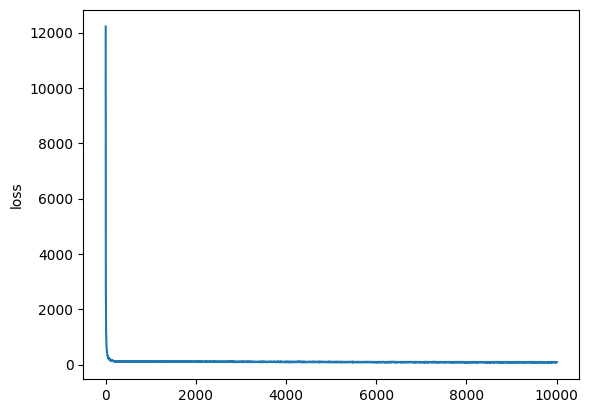

In [75]:
import matplotlib.pyplot as plt

plt.plot(list_o_loss)
# plt.ylim([0, 10])
plt.ylabel('loss')
plt.show()

## TensorBoard

**TODO:**
* investigate `Losses/regularization_loss`

In [79]:
# %load_ext tensorboard
%reload_ext tensorboard

In [77]:
# %tensorboard --logdir=$train_log_dir

**Gradient summaries**

<p align="center">
    <img src='imgs/summary_gradients_tb.png' width='1200'/>
</p>


**Var histograms**

<p align="center">
    <img src='imgs/histograms_tb.png' width='1200'/>
</p>

In [84]:
# eval_log_dir

# %tensorboard --logdir=$eval_log_dir

'gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-rec-topk-v1/run-20241122-184115/logs/eval'

In [101]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

# Inference

Create an inference dataset:

In [87]:
inference_dataset = create_tfrecord_ds(
    tf.io.gfile.glob(val_files),
    process_example_fn=process_example_fn,
    batch_size=1,
    num_shards=len(val_files),
    repeat=False,
    drop_remainder=True
)
infer_batch = list(inference_dataset.take(1))[0]
traj_infer, weights_infer = infer_batch

traj_infer

Trajectory(
{'action': <tf.Tensor: shape=(1, 10), dtype=int64, numpy=array([[  95, 3107,  290, 2847,    5, 2502,  476, 3045, 2326,    0]])>,
 'discount': <tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 10), dtype=int64, numpy=array([[ 293,   95, 3107,  290, 2847,    5, 2502,  476, 3045,    0]])>,
 'policy_info': (),
 'reward': <tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[5., 3., 5., 4., 3., 4., 2., 4., 3., 0.]], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=array([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>})

In [88]:
weights_infer

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]], dtype=float32)>

Check initial policy state:

In [89]:
policy_state = tf_agent.policy.get_initial_state(traj_infer.step_type.shape[0])
policy_state

((ListWrapper([<tf.Tensor: shape=(1, 25), dtype=float32, numpy=
  array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>, <tf.Tensor: shape=(1, 25), dtype=float32, numpy=
  array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>]),),)

Generate predictions for each step:

In [90]:
traj_infer.step_type.shape[1]

10

In [91]:
predicted_actions = []

for i in tf.range(traj_infer.step_type.shape[1]):

    observation = traj_infer.observation[:, i, tf.newaxis]
    step_type = traj_infer.step_type[:, i, tf.newaxis]
    time_step = ts.TimeStep(
        step_type=step_type,
        observation=observation,
        reward=tf.zeros_like(step_type, tf.float32),
        discount=tf.ones_like(step_type, tf.float32)
    )

    action_step = tf_agent.policy.action(time_step, policy_state)
    policy_state = action_step.state
    predicted_actions.append(action_step.action)

In [92]:
predicted_actions

[<tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[ 604,  293, 1195,  589, 2693]])>,
 <tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[1656,  604,  293, 1195,   24]])>,
 <tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[ 293,  604, 2693, 3078,   49]])>,
 <tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[ 453, 1568,  108, 3078, 2502]])>,
 <tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[1568,  453, 3349,  373,    5]])>,
 <tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[1568,  453, 3349,  373,    5]])>,
 <tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[1568,  453, 3349,  470,    5]])>,
 <tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[2847, 1568,  373, 3187,  724]])>,
 <tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[3107, 3078, 2693, 2928, 2614]])>,
 <tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[2693,  220, 2928, 1245,   33]])>]

Check policy state now:

In [93]:
action_step.state

((ListWrapper([<tf.Tensor: shape=(1, 25), dtype=float32, numpy=
  array([[ 0.3267586 , -0.7355204 , -0.9962924 , -0.9961593 ,  0.6748876 ,
           0.3188045 , -0.7840215 ,  0.18547933,  0.20696203,  0.7223773 ,
          -0.9750901 ,  0.21134734, -0.13331994, -0.7303762 , -0.79875267,
           0.48667616,  0.11983376, -0.8934608 , -0.98590976,  0.5425591 ,
           0.02740378, -0.72694683,  0.73088706,  0.23428164, -0.78795624]],
        dtype=float32)>, <tf.Tensor: shape=(1, 25), dtype=float32, numpy=
  array([[ 0.36044252, -0.9428246 , -3.2312407 , -4.798354  ,  0.8309968 ,
           0.3362579 , -1.0557446 ,  0.19161415,  0.2100969 ,  0.91275525,
          -2.1877503 ,  0.21458471, -0.13415602, -0.947164  , -1.0981687 ,
           0.53183675,  0.12049197, -1.4534069 , -2.5966597 ,  5.8159447 ,
           0.02741293, -1.1071931 ,  0.9378762 ,  0.23871554, -1.1059433 ]],
        dtype=float32)>]),),)

In [94]:
observed_actions = tf.expand_dims(traj_infer.action, axis=2)
observed_actions

<tf.Tensor: shape=(1, 10, 1), dtype=int64, numpy=
array([[[  95],
        [3107],
        [ 290],
        [2847],
        [   5],
        [2502],
        [ 476],
        [3045],
        [2326],
        [   0]]])>

In [95]:
predicted_actions_stacked = tf.stack(predicted_actions, axis=1)
predicted_actions_stacked

<tf.Tensor: shape=(1, 10, 5), dtype=int64, numpy=
array([[[ 604,  293, 1195,  589, 2693],
        [1656,  604,  293, 1195,   24],
        [ 293,  604, 2693, 3078,   49],
        [ 453, 1568,  108, 3078, 2502],
        [1568,  453, 3349,  373,    5],
        [1568,  453, 3349,  373,    5],
        [1568,  453, 3349,  470,    5],
        [2847, 1568,  373, 3187,  724],
        [3107, 3078, 2693, 2928, 2614],
        [2693,  220, 2928, 1245,   33]]])>

In [96]:
correct_predictions = tf.reduce_any(
    predicted_actions_stacked == observed_actions, axis=2
)
correct_predictions

<tf.Tensor: shape=(1, 10), dtype=bool, numpy=
array([[False, False, False, False,  True, False, False, False, False,
        False]])>

In [97]:
print('Correct Predictions:')
print(correct_predictions)
print('-' * 80)

Correct Predictions:
tf.Tensor([[False False False False  True False False False False False]], shape=(1, 10), dtype=bool)
--------------------------------------------------------------------------------


In [98]:
print('Observed Actions (vocab):')
print(action_lookup_layer(traj_infer.action))

Observed Actions (vocab):
tf.Tensor([[  96 3108  291 2848    6 2503  477 3046 2327    1]], shape=(1, 10), dtype=int64)


In [99]:
print('Predicted Actions (vocab):')
print(action_lookup_layer(predicted_actions))
print('-' * 80)

Predicted Actions (vocab):
tf.Tensor(
[[[ 605  294 1196  590 2694]]

 [[1657  605  294 1196   25]]

 [[ 294  605 2694 3079   50]]

 [[ 454 1569  109 3079 2503]]

 [[1569  454 3350  374    6]]

 [[1569  454 3350  374    6]]

 [[1569  454 3350  471    6]]

 [[2848 1569  374 3188  725]]

 [[3108 3079 2694 2929 2615]]

 [[2694  221 2929 1246   34]]], shape=(10, 1, 5), dtype=int64)
--------------------------------------------------------------------------------


In [100]:
print('Observed Actions (raw):')
print(traj_infer.action)
print('-' * 80)
print('Predicted Actions (raw):')
print(predicted_actions)

Observed Actions (raw):
tf.Tensor([[  95 3107  290 2847    5 2502  476 3045 2326    0]], shape=(1, 10), dtype=int64)
--------------------------------------------------------------------------------
Predicted Actions (raw):
[<tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[ 604,  293, 1195,  589, 2693]])>, <tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[1656,  604,  293, 1195,   24]])>, <tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[ 293,  604, 2693, 3078,   49]])>, <tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[ 453, 1568,  108, 3078, 2502]])>, <tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[1568,  453, 3349,  373,    5]])>, <tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[1568,  453, 3349,  373,    5]])>, <tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[1568,  453, 3349,  470,    5]])>, <tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[2847, 1568,  373, 3187,  724]])>, <tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[3107, 3078, 2693, 2928, 261

# Notes n stash

## Experiment ideas

**Create experiment comparing:**

[1] rnn
* off_policy_correction_exponent = None
* use_supervised_loss_for_main_policy = True

[2] REINFORCE
* off_policy_correction_exponent = None
* use_supervised_loss_for_main_policy = False

[3] topk REINFORCE
* off_policy_correction_exponent = ~16
* use_supervised_loss_for_main_policy = False

## synthetic data for tutorial/demo

Create dummy item IDs and embeddings like [src](https://www.tensorflow.org/recommenders/examples/efficient_serving#tuning_scann)

```
# Construct a dataset of movies that's 1,000 times larger. We 
# do this by adding several million dummy movie titles to the dataset.
lots_of_movies = tf.data.Dataset.concatenate(
    movies.batch(4096),
    movies.batch(4096).repeat(1_000).map(lambda x: tf.zeros_like(x))
)

# We also add lots of dummy embeddings by randomly perturbing
# the estimated embeddings for real movies.
lots_of_movies_embeddings = tf.data.Dataset.concatenate(
    movies.batch(4096).map(model.movie_model),
    movies.batch(4096).repeat(1_000)
      .map(lambda x: model.movie_model(x))
      .map(lambda x: x * tf.random.uniform(tf.shape(x)))
)
```

#### TODO: optimize train step

In [ ]:
@common.function(autograph=False)
def _train_step_fn(data):
    
    # trajectory, weights = data

    def replicated_train_step(experience):
        return tf_agent.train(experience).loss

    per_replica_losses = distribution_strategy.run(
        replicated_train_step, 
        args=(data,)
    )

    # return agent.train(experience=trajectories).loss
    return distribution_strategy.reduce(
        tf.distribute.ReduceOp.MEAN, 
        per_replica_losses, # loss, 
        axis=None
    )

#### TODO: record summary within scope?

In [ ]:
# with tf.compat.v2.summary.record_if(
#     lambda: tf.math.equal(global_step % summary_interval, 0)):

```
    @common.function(autograph=False)
    def _train_step_fn(data):
        
        def replicated_train_step(experience):
            return agent.train(experience).loss
        
        trajectories = _trajectory_fn(data)

        per_replica_losses = distribution_strategy.run(
            replicated_train_step, 
            args=(trajectories,)
        )

        # return agent.train(experience=trajectories).loss
        return distribution_strategy.reduce(
            tf.distribute.ReduceOp.MEAN, 
            per_replica_losses, # loss, 
            axis=None
        )
        
    ...
    
    loss = _train_step_fn(data)
```